# Import Libraries

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

import joblib

sns.set(style="whitegrid")


# Load Dataset

In [22]:
df = pd.read_csv("../data/Loan-Approval-Prediction.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# DROP USELESS COLUMN

In [23]:
df.drop("Loan_ID", axis=1, inplace=True)


# HANDLE MISSING VALUES

In [24]:
cat_cols = ["Gender", "Married", "Dependents",
            "Education", "Self_Employed", "Property_Area"]

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

num_cols = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_7440\467839285.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_7440\467839285.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

# VISUALIZATION 1: LOAN STATUS DISTRIBUTION

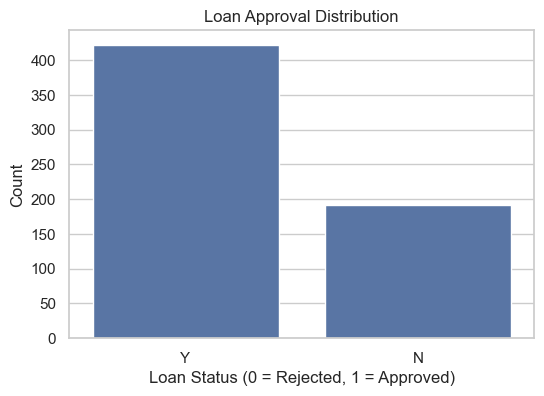

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x="Loan_Status", data=df)
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Status (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.show()


# ENCODE CATEGORICAL DATA

In [26]:
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])


# VISUALIZATION 2: CREDIT HISTORY vs LOAN STATUS

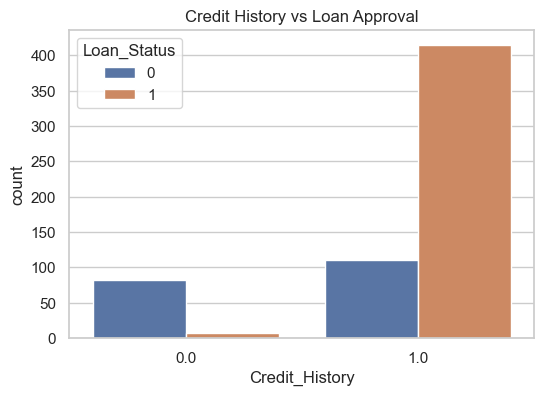

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x="Credit_History", hue="Loan_Status", data=df)
plt.title("Credit History vs Loan Approval")
plt.show()


# FEATURE ENGINEERING

In [28]:
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["Loan_Income_Ratio"] = df["LoanAmount"] / df["TotalIncome"]


# VISUALIZATION 3: APPLICANT INCOME DISTRIBUTION

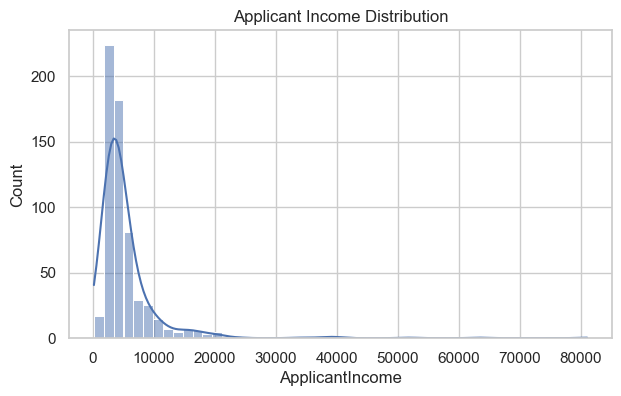

In [29]:
plt.figure(figsize=(7,4))
sns.histplot(df["ApplicantIncome"], kde=True)
plt.title("Applicant Income Distribution")
plt.show()


# VISUALIZATION 4: LOAN AMOUNT vs TOTAL INCOME

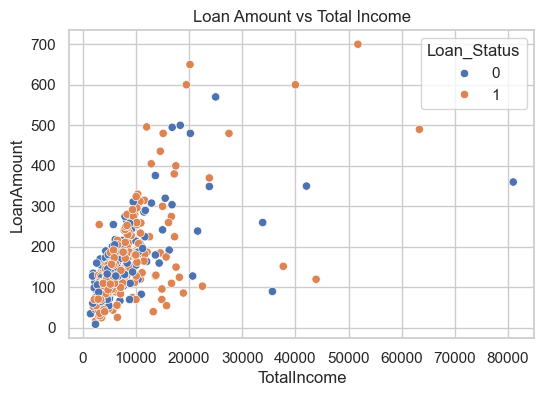

In [30]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="TotalIncome",
    y="LoanAmount",
    hue="Loan_Status",
    data=df
)
plt.title("Loan Amount vs Total Income")
plt.show()


# FEATURES & TARGET

In [31]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

print("Total features:", X.shape[1])  # MUST be 13


Total features: 13


# TRAIN TEST SPLIT

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# LOGISTIC REGRESSION (WITH SCALING)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7804878048780488


# VISUALIZATION 5: CONFUSION MATRIX (LR)

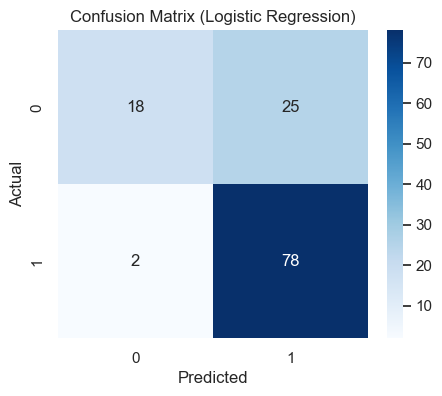

In [34]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


# RANDOM FOREST MODEL (NO SCALING)

In [35]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:",
      accuracy_score(y_test, rf_pred))


Random Forest Accuracy: 0.7804878048780488


# HYPERPARAMETER TUNING 

In [36]:
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    cv=5,
    scoring="accuracy"
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 5, 'n_estimators': 200}


# VISUALIZATION 7: FEATURE IMPORTANCE

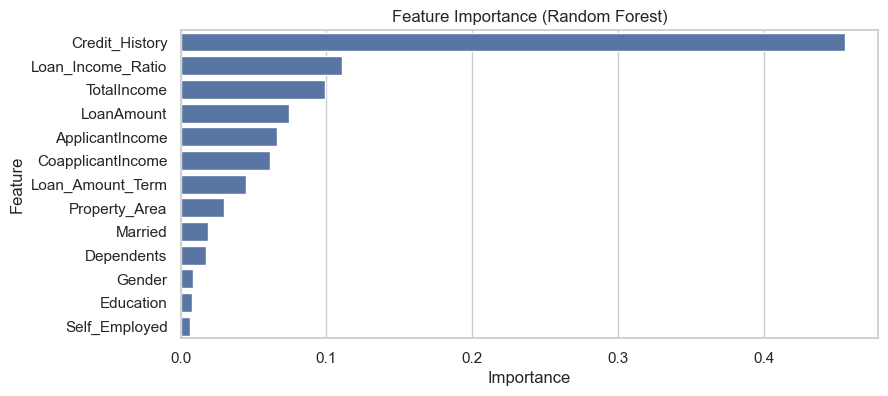

In [37]:
importance = best_model.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(9,4))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Feature Importance (Random Forest)")
plt.show()


# FINAL EVALUATION (RF)

In [38]:
y_prob_rf = best_model.predict_proba(X_test)[:,1]

print("ROC AUC (Random Forest):",
      roc_auc_score(y_test, y_prob_rf))


ROC AUC (Random Forest): 0.7511627906976744


# SAVE MODELS

In [39]:
joblib.dump(lr, "../model/logistic_model.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
joblib.dump(best_model, "../model/best_loan_model.pkl")


['../model/best_loan_model.pkl']